# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 14
### <center> Yoshihiro Shirai

# Training Neural Networks, Part 1

- These lecture notes are partially based on "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurelien Geron (O'Reilly), 2022."

- Chapter 11: vanishing/exploding gradients, weight initialization, nonsaturating activation functions, batch normalization.

#  0. Overview of the lecture

- We begin by introducing the **fashion MNIST** dataset, a benchmark for neural networks which is more difficult to model than the original MNIST dataset.

- We discuss one of the main challenges in training deep neural networks, namely the **vanishing/exploding gradients** problem that makes lower layers of DNNs difficult to train.

- We discuss three approaches to deal with this challenge: **weight initialization**, **non-saturating activation functions**, and **batch normalization**.

# 1. Fashion MNIST

- As we mentioned before, MNIST has become a benchmark for ML. The consensus is "If it doesn't work on MNIST, it won't work at all".

- However, MNIST is too "easy". Most classical methods can easily achieve above 97% accuracy. Shallow convolutional neural networks (to be introduced later), can achieve 99.7% accuracy.

- For this reason, the fashion MNIST dataset is used as an alternative benchmark. It consists of images of fashion items and their labels. The structure of the data is identical to MNIST.

- However, it is more difficult to train, which makes it a better benchmark. For example, a simple linear model reaches about 92% accuracy on MNIST, but only about 83% on Fashion MNIST.

- Let us load fashion MNIST from `tensorflow.keras`.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


- The Fashion MNIST dataset has 70,000 observations (60,000 training data, 10,000 test data). Each observation has 784 features as $28\times 28$ pixel image. Labels are digits  $0,1,...,9$.

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
print("training set dimension: {}, test set dimension: {}"
      .format(X_train_full.shape, X_test.shape))

training set dimension: (60000, 28, 28), test set dimension: (10000, 28, 28)


In [5]:
X_train_full.dtype

dtype('uint8')

In [6]:
np.unique(y_train_full)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

- The pixel values ranging from 0 to 255 are integers. We scale the features by dividing them by 255.0, converting them to floats.

In [7]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

- Here is the first image.

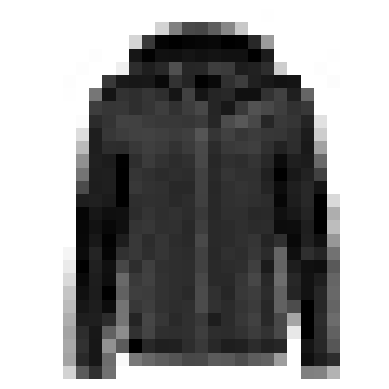

In [8]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

- Here are the class names corresponding to each of the 10 labels.

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

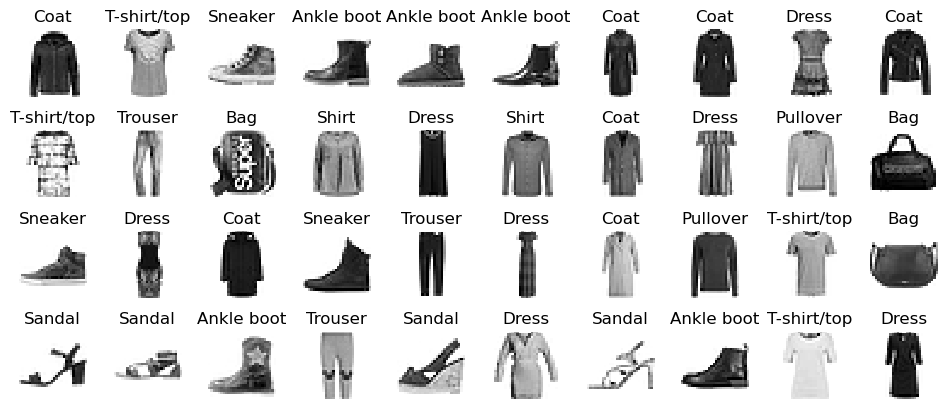

In [10]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Let us consider the MLP that we trained on MNIST in the previous lecture. Note that every image is stored as a $28\times 28$ array, so we need to convert them to a 1D array.

- We train the MLP using tensorflow.keras. First, we create the neutral network.

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [12]:
model.layers

- You can get a nice summary of a Keras model using .summary() method.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


- You can also access all the parameters of the ANN.

In [14]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [15]:
model.get_layer(hidden1.name).name

'dense'

In [16]:
weights, biases = hidden1.get_weights()

In [17]:
weights.shape

(784, 300)

In [18]:
weights

array([[ 0.02367634,  0.0236733 , -0.02972456, ..., -0.07322972,
        -0.01889252, -0.04143866],
       [-0.03973795, -0.02822305,  0.01102232, ...,  0.01300287,
         0.00950678, -0.01973418],
       [ 0.0152857 ,  0.0255484 ,  0.03305814, ...,  0.0205282 ,
        -0.06344451,  0.06203383],
       ...,
       [-0.02270378,  0.05841962,  0.00948665, ...,  0.05556314,
         0.04462706, -0.04239127],
       [ 0.04007033,  0.00604625, -0.04285778, ...,  0.06329554,
        -0.05230941, -0.02865128],
       [ 0.03863423,  0.05443865,  0.0207632 , ...,  0.01412423,
        -0.01874111,  0.0021918 ]], dtype=float32)

In [19]:
biases.shape

(300,)

In [20]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

- Let us train the model on the full dataset.

In [21]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [22]:
history = model.fit(X_train, y_train, epochs=15,
                    validation_data=(X_valid, y_valid))

Epoch 1/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7214 - accuracy: 0.7617 - val_loss: 0.5047 - val_accuracy: 0.8312
Epoch 2/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4905 - accuracy: 0.8288 - val_loss: 0.4421 - val_accuracy: 0.8466
Epoch 3/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4461 - accuracy: 0.8434 - val_loss: 0.4344 - val_accuracy: 0.8514
Epoch 4/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4191 - accuracy: 0.8523 - val_loss: 0.3982 - val_accuracy: 0.8636
Epoch 5/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3997 - accuracy: 0.8592 - val_loss: 0.4047 - val_accuracy: 0.8564
Epoch 6/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3841 - accuracy: 0.8644 - val_loss: 0.3832 - val_accuracy: 0.8640
Epoch 7/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3722 - accuracy: 0.8696 - val_loss: 0.3706 - val_accuracy:

- To get the a learning curve (i.e. the training and validation errors versus epochs), we can use the ``.history`` property of the output of the ``.fit()`` of a Keras model.

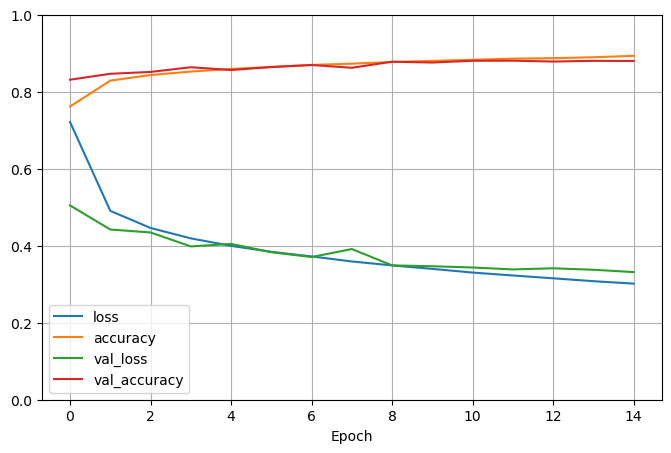

In [24]:
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), ylim=[0, 1], grid=True, xlabel="Epoch")
plt.legend(loc="lower left")  # extra code
plt.show()

In [25]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3675 - accuracy: 0.8676


[0.36754122376441956, 0.8676000237464905]

- We get a 87% accuracy on the test set. This is much lower than the MNIST dataset. So, classification of fashion MNIST is indeed more difficult.
- Let us also show some predictions.
- ``.predict()`` of a fitted model returns the class probabilities.

In [26]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 68ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.06, 0.  , 0.9 ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

- To get the predicted labels, use `np.argmax`.

In [27]:
model.predict(X_new).shape

1/1 [==============================] - 0s 20ms/step


(3, 10)

In [28]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 18ms/step


array([9, 2, 1], dtype=int64)

In [29]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

- We can check if the classifier is correct in this case.

In [30]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

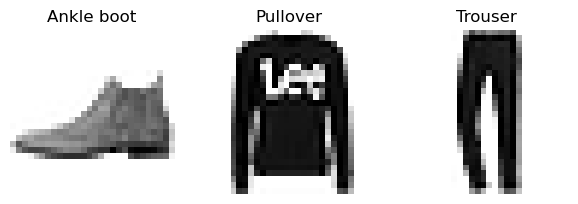

In [31]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- So far, we have trained rather shallow networks. More complex applications may need deep ANNs, say 10 hidden layers of hundreds of neurons each.

- For training such DNNs, we will face several challenges. The most common ones are as follows.

    - **Vanishing gradients** and **exploding gradients**: The gradient may be very small or very large, making the neural network hard to train.

    - **Slow training**: The "vanilla" GD algorithm may be very slow.

    - **Not enough (labeled) data**: Training large networks requires a large amount of labeled data. Such data may not be available, or may be too costly to label.

    - **Overfitting**: A very deep DNN will have millions of parameters and, therefore, is prone to overfitting the training set.

- Today, we discuss the first challenge, namely, vanishing/exploding gradients. In the next lecture, we will discuss the remaining challenges.

# 2. Vanishing/exploding gradient problem

- Recall that we use gradient descent or its variations to train ANNs.

- In each iteration, we calculate the gradient with a forward and a reverse pass (backpropagation). The reverse pass starts with the output later and moves towards the input layer, calculating the partial derivatives with respect to each connection weight.

- It is common for the partial derivatives to get smaller as you move toward the input layer. As a result, the GD iteration will not change the weight of the lower layers. In other words, the lower layers stay mostly fixed. This phenomenon is called the **vanishing gradients** problem.

- In some ANNs (such as recurrent neural networks), the reverse happens. In the reverse pass, the gradients become larger and larger, causing the weights in the lower layers to change lot and diverge. This is called the **exploding gradients** problem.

- In general, DNNs suffer from **unstable gradients**, in the sense that the learning speed (i.e. the size of the gradients) may be widely different for different layers.

- As it turns out, the unstable gradient problem results from the interaction between the activation function and how the weights are initialized. In particular, a 2010 article by Xavier Glorot and Yoshua Bengio showed that the combination of the logistic activation function and standard normal initialization results in higher variance in the outputs of the higher layers.

- Since the logistic function saturates for large input sizes (i.e. it becomes almost constant), the gradient of the higher layers will be small. So, when we do the reverse pass, these small gradients will become even smaller, resulting in vanishing gradients.

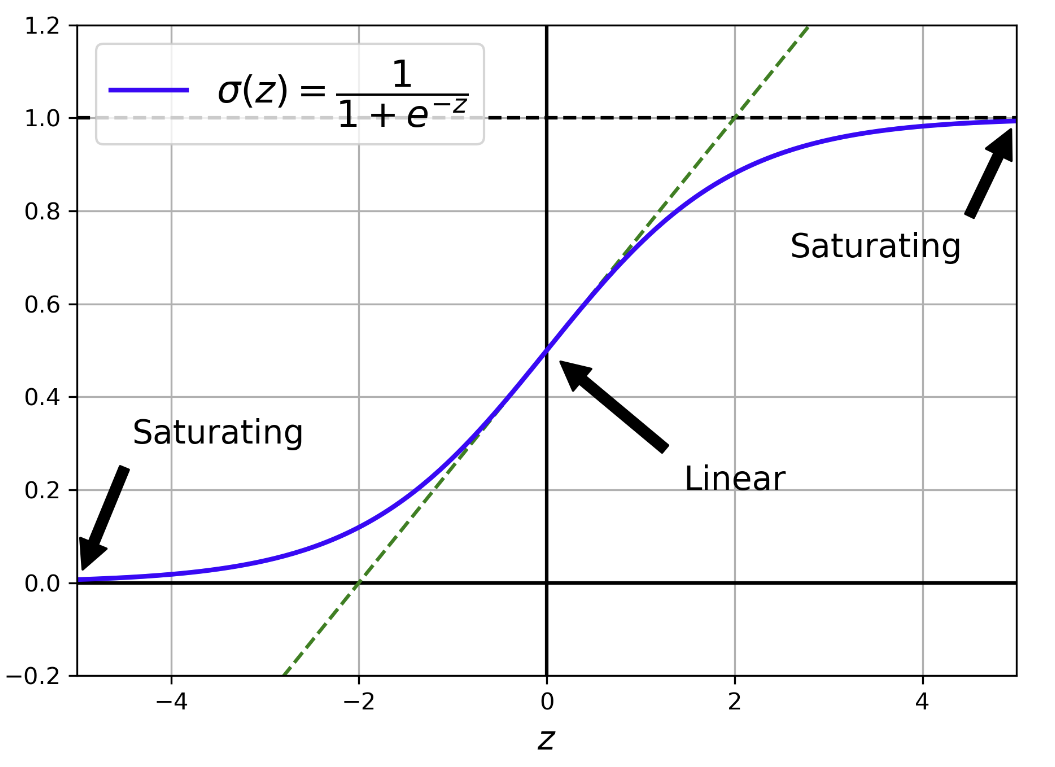

In [32]:
from IPython.display import Image
Image("Figs/sigmoid_saturation_plot.png",width=600)

# 3. Weight initialization

- A very simple, yet very important, trick alleviates vanishing gradient problem.

- Instead of using standard normal initial connection weights, use a distribution with mean 0 and variance that is a function of the number of inputs (called **fan-in**) and the number of neurons (called **fan-out**) of each layer. The distribution is either normal or uniform. The variance depends on the activation function used, as follows.

- If activation function is the **identity** function (i.e. no activation), **tanh**, **logistic**, or **softmax**, use the variance  $\tfrac{2}{\text{fan-in}+\text{fan-out}}$. This activation is called **Glorot** initialization or **Xavier** initialization.

- If activation function is the **ReLU**, **leakly ReLU** or **ELU** (see later), use the variance $\tfrac{2}{\text{fan-in}}$. This is called **He** initialization.

- If activation function is **SELU** (see later), use the variance $\tfrac{1}{\text{fan-in}}$. This is called **LeCun** initialization.

- In Keras, you can use the initialization method when you are defining the layers.

- The default initialization is Glorot with uniform distribution.

- To use, say, He initialization with normal distribution, you can use

In [33]:
tf.keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

- The available initializations are as follows:

In [34]:
[name for name in dir(tf.keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

# 4. Nonsaturating activation

- As we mentioned, one of the main reasons for the vanishing gradient problem is that logistic and tanh activation saturates for large inputs (i.e. they become flat).

- Thus, using a nonsaturating activation function such as ReLU helps.

- ReLU suffers from a problem known as **dying ReLUs**. During training of a DNN, the connection weights can take values such that weighted sums of the inputs of a given neuron are negative for all the observations in the training sample. In such a case, that ReLU neuron never activates during the training (in other words, it "dies"). In some cases, more than half of ReLU neurons may die during training of large DNNs.

- Many variants of ReLU have been suggested to fight the dying ReLUs problem.


- We may use a **leaky ReLU**, where the activation function is
$$\begin{align*}
\text{LeakyReLu}_{\alpha}(t)=\max\{\alpha t,t\}
\end{align*}$$

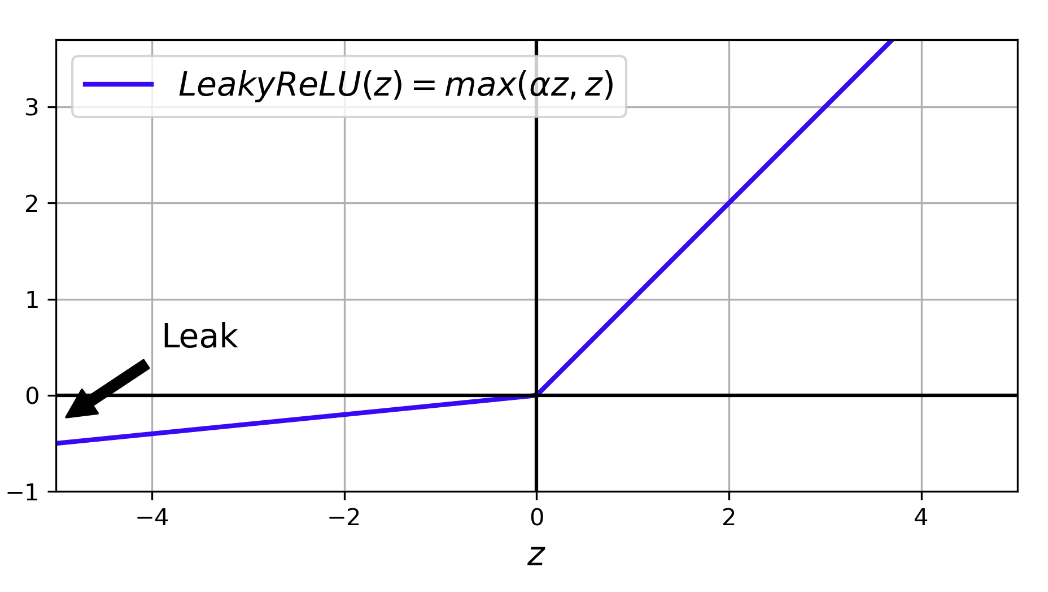

In [35]:
Image("Figs/leaky_relu_plot.png",width=600)

- The small slope $\alpha$ for $t<0$ which is called the **leak**, ensures that leaky ReLU neurons don't die (they may suffer from long "comas", though).

- The parameter  $\alpha$ is usually set to 0.01 (a small leak). Empirical studies observe that the leaky ReLU performs better than the ReLU and in some cases $\alpha = 0.2$ (a large leak) results in better performance.

- Another approach to choose $\alpha$ is to treat it as a parameter (like the weights). This is called **parametric leaky ReLU (PReLU)**. It has been observed that this outperforms ReLU on large datasets, but it tends to overfit small datasets.

- Another nonsaturating activation function is called the **exponential linear unit (ELU)**:
$$\begin{align*}
\text{ELU}_{\alpha}(t) = \begin{cases}
t; \quad \quad & t\geq 0,\\
\alpha(e^t-1); \quad\quad &t<0
\end{cases}
\end{align*}$$

- The default value of $\alpha$ is 1. As in the case of ReLU, we can use $\alpha$ as a hyperparameter (and tune them with grid search) or, we can treat them as a parameter and learn it during training.

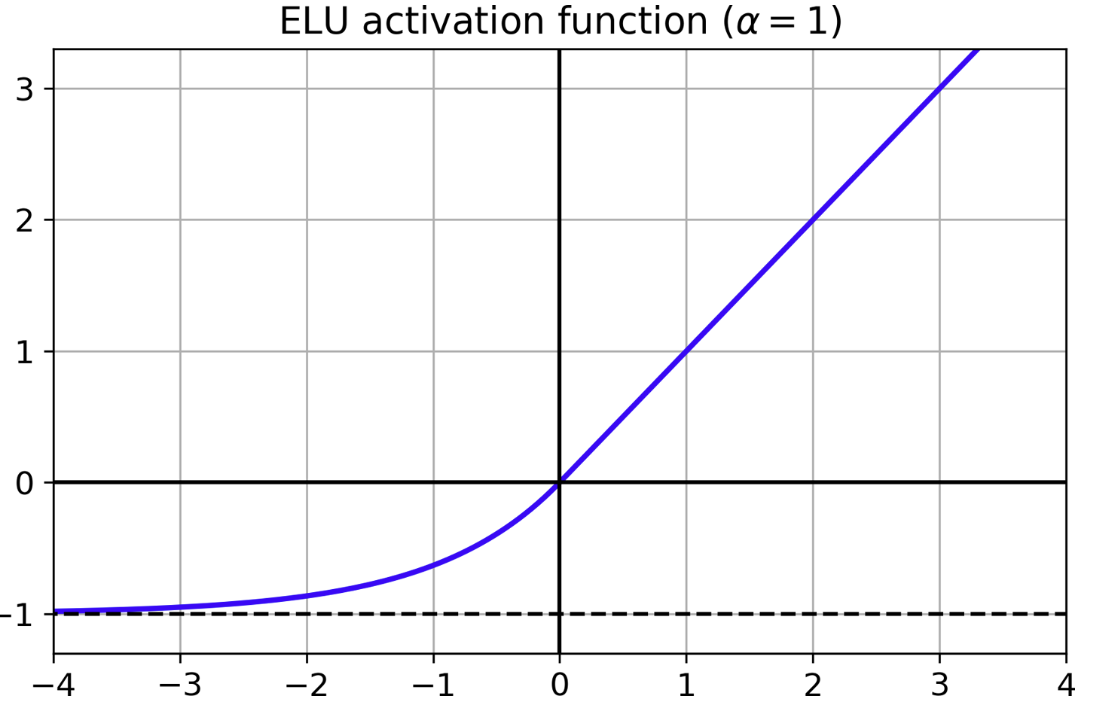

In [36]:
Image("Figs/elu_plot.png",width=600)

- ELU has all the benefits of leaky ReLU.

- It takes on negative values when the argument is negative, which allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem.

- Its gradient is nonzero, avoiding the dying ReLUs problem.

- The downside of using ELU is that its evaluation is slower due to the use of the exponential function.

- In practice, using ELU makes training faster (its slower evaluation time is compensated by its faster convergence rate). However, evaluating over the test set and prediction are generally slower.


- Another non-saturating activation function is the scaled exponential linear unit (SELU) function
$$\begin{align*}
\text{SELU}_{\alpha,\lambda}(t) = \lambda\begin{cases}
t; \quad \quad & t\geq 0,\\
\alpha(e^t-1); \quad\quad &t<0
\end{cases}
\end{align*}$$

- By default, $\alpha \approx 1.67326$ and $\lambda \approx 1.0507$  are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too).

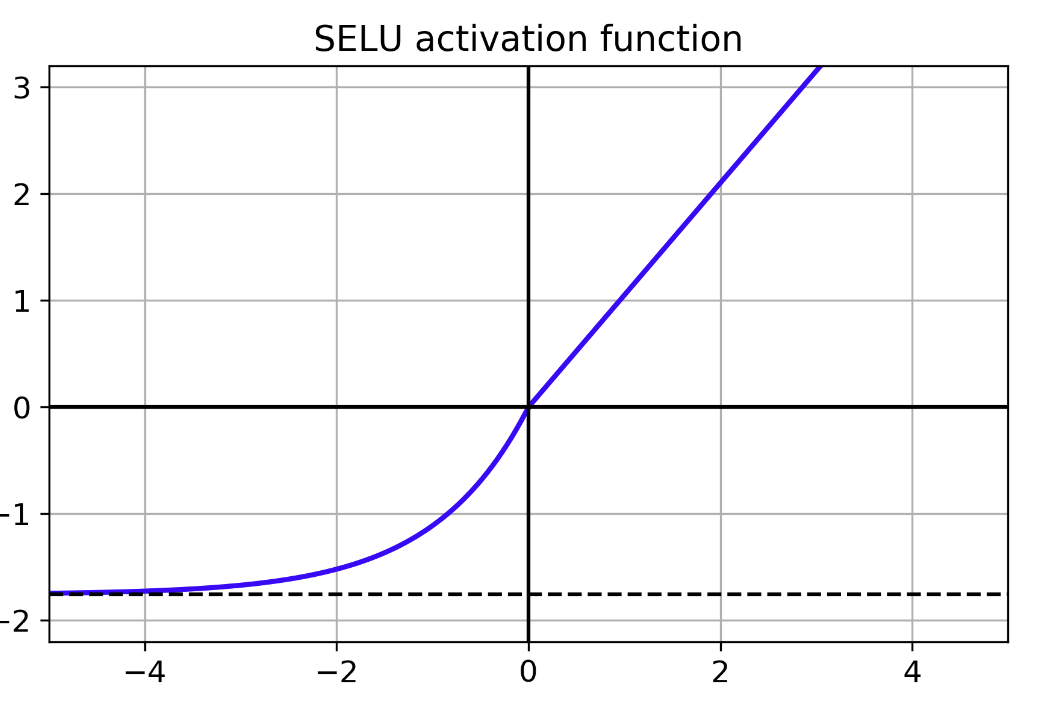

In [37]:
Image("Figs/selu_plot.png",width=600)

- The main advantage of the SELU activation function is that, under some conditions (most notably, the inputs must be standardized, one must use LeCun normal initialization, and the network architecture must be sequential and dense), it makes the ANN self-normalize. In such a case, the output of each layer tends to preserve an average of 0 and variance of 1 during training, which solves the vanishing/exploding gradient problem.

- This benefit is not guaranteed otherwise. In practice, simply try this activation function and see if it works well.

- There are two recent variants of ReLU that empirical work shows perform better than previous variants.

- These are **GELU** and **Swish**, which have a more complex, non-monotonic shape than the previous ReLU variants.

- They are defined by $$\begin{align*}\text{GELU}(t)=t\Phi(t)\end{align*},$$ and $$\begin{align*}\text{Swish}(t)=\sigma(t),\end{align*}$$ where $\Phi$ and $\sigma$ are the standard normal cdf and sigmoid function respectively.

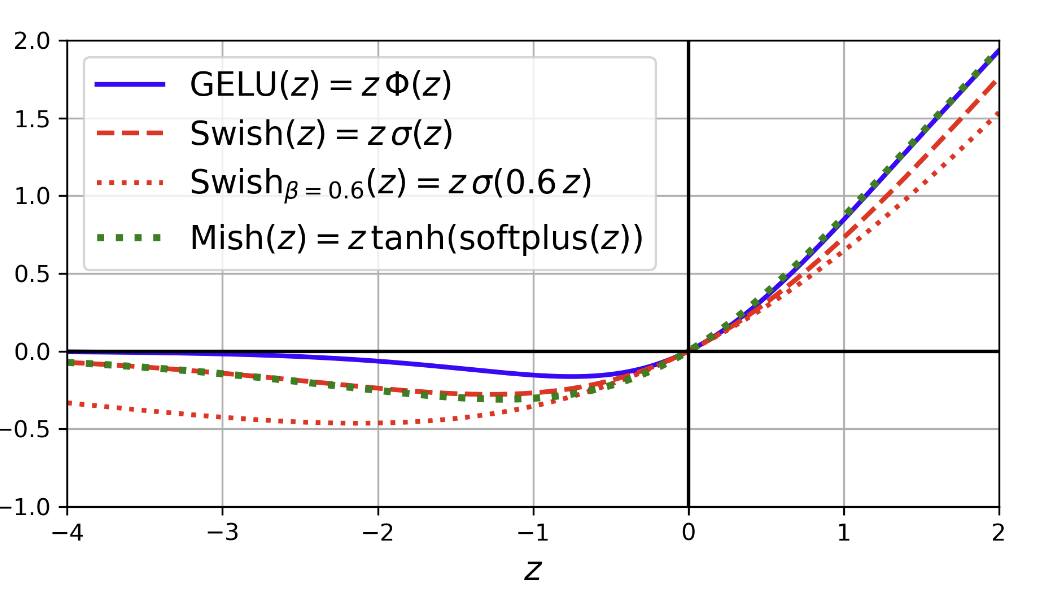

In [39]:
Image("Figs/gelu_swish_mish_plot.png",width=600)

- As a rule of thumb, use the following preferences when choosing the activation function for DNNs.
$$\text{Swish > GELU > SELU > ELU > LeakyReLU (and its variants) > ReLU > tanh > logit.}$$

- Usually ReLU or leaky ReLU is a good default for most simple tasks.

- Swish and GELU may tend to have better performance for more complex tasks, but at the cost of being slower to train.

- Remember to use the correct initialization. That is
    - He initialization for ReLU (and its variants) and ELU.
    - LeCun initialization for SELU.
    - Glorot initialization for other activation functions.

- Most activation functions are available through `tensorflow.keras.activations`.

In [40]:
[m for m in dir(tf.keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

- Additional activation functions, most notably variations of ReLU, are implemented in `tensorflow.keras.layers`

In [41]:
[m for m in dir(tf.keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

- To choose an activation, use the `activation=` argument of layers.

- Let us train a variant of the MLP that we trained for fashion MNIST before, this time using leaky ReLU. We use 5 epochs for demonstration purposes.

In [42]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
layer = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")
layer.activation

In [43]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation=leaky_relu,
                       kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation=leaky_relu, 
                       kernel_initializer="he_normal"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [44]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [45]:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6973 - accuracy: 0.7646 - val_loss: 0.5183 - val_accuracy: 0.8238
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4819 - accuracy: 0.8304 - val_loss: 0.4377 - val_accuracy: 0.8498
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4395 - accuracy: 0.8443 - val_loss: 0.5508 - val_accuracy: 0.7944
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4146 - accuracy: 0.8557 - val_loss: 0.3998 - val_accuracy: 0.8610
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3976 - accuracy: 0.8609 - val_loss: 0.3832 - val_accuracy: 0.8674


- Next, let us train a DNN with 100 layers using SELU activation functions.

In [46]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [47]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

- Don't forget that to get the benefit of SELU, that is, self-normalization, you have to standardize the inputs.

In [48]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [49]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 16s 8ms/step - loss: 1.1725 - accuracy: 0.5618 - val_loss: 0.9191 - val_accuracy: 0.6868
Epoch 2/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.8371 - accuracy: 0.6957 - val_loss: 0.8874 - val_accuracy: 0.6906
Epoch 3/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.9676 - accuracy: 0.6450 - val_loss: 1.1870 - val_accuracy: 0.5046
Epoch 4/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.8848 - accuracy: 0.6818 - val_loss: 0.7136 - val_accuracy: 0.7482
Epoch 5/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.6800 - accuracy: 0.7555 - val_loss: 0.6084 - val_accuracy: 0.7838


- The neural network managed to learn, despite how deep it is.

- Let us train another DNN, this time using ReLU.

In [50]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [51]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [52]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 15s 7ms/step - loss: 2.0238 - accuracy: 0.2100 - val_loss: 1.7903 - val_accuracy: 0.2962
Epoch 2/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.4870 - accuracy: 0.3995 - val_loss: 1.1881 - val_accuracy: 0.5216
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.3000 - accuracy: 0.4713 - val_loss: 1.3331 - val_accuracy: 0.4448
Epoch 4/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.0405 - accuracy: 0.5839 - val_loss: 0.9251 - val_accuracy: 0.6330
Epoch 5/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9540 - accuracy: 0.6252 - val_loss: 0.8847 - val_accuracy: 0.6272


- The convergence rate is lower, most probably because of dying ReLUs.

# 5. Batch Normalization (BN)

- As we saw, the main reason for the vanishing/exploding gradients is that the outputs of the layers are not "standardized".

- The choice of activation functions and initialization method can significantly help with this problem **at the beginning** of the training. There is, however, no guarantee that the vanishing/exploding gradient problem will not happen later during the training.

- The only exception is SELU activation with LeCun normal initialization which, under special circumstances, self-normalizes the inputs during training.

- **Batch normalization (BN)** is a technique that actively seeks to keep the inputs standardized during the training. It involves adding additional operations to standardize the inputs before passing them to the neurons.

- BN works as follows. Assume that we are training the network with mini-batch GD. Each batch is of size $N_B$.

- In each iteration of the mini-batch GD, let $x_{n,i}$ be the output of neuron $i$, assuming the network has been inputed by the $n$-th observation in the mini-batch. Note that $i$ can be a passthrough neuron in the input layer. Thus, BN can be directly applied to the inputs as well.

- We first find the sample mean and variance of each output:
$$\mu_i=\frac{1}{N_B}\sum_{n=1}^{N_B}x_{n,i}, \quad \sigma_i^2 =\frac{1}{N_B}\sum_{n=1}^{N_B}(x_{n,i}-\mu_i)^2$$

- We then standardize the output as follows
$$\hat{x}_{n,i}=\frac{x_{n,1}-\mu_i}{\sqrt{\sigma_i^2+\varepsilon}}$$

- Here, the smoothing term $\varepsilon>0$ is a small number and is included to avoid division by zero.

- Finally, we shift and scale the standardized output
$$z_{n,i}=\gamma_i\hat{x}_i+\beta_i$$

- $\gamma_i$ and $\beta_i$ are two parameters that will be learned during training. That is, they are changed by backpropogation the same way that the connection weights are changed.

- We use $z_{n,i}$ as the inputs of the next layer (instead of $x_n,i$).

- Note that BN adds 2 parameters per neuron during training. It also involves some extra steps (standardizing and shift-scaling), which are time consuming.

- However, it has been shown that BN can considerably reduce the vanishing gradient problem during training to an extent that saturated activation functions such as tanh and logistic functions can be used for training DNNs. BN also makes training much less sensitive to the initialization method. As a consequence, one can use a higher learning rate in GD iterations, which can dramatically improve the convergence rate.

- As a bonus, BN also acts like a regularization technique, and reduces overfitting.

- How can we use it for prediction and evaluation on the test/validation sets?

- Looking at the BN algorithm, it becomes clear that, during prediction (i.e. the forward pass), we need four parameters per output, namely, $\mu_i$, $\sigma_i^2$, $\gamma_i$, and $\beta_i$.

- \gamma_i$ and $\beta_i$ are obtained during training. So, we can just use their fitted value (the same way that we use the fitted connection weights).

- $\mu_i$ and $\sigma_i$, however, were not estimated. They were simply inferred from the mini-batch.

- Assume that we want to predict based on just 1 new observation. There is no sample to find the sample average and variance. What should we do?

- One approach is to use the average of $(\mu_i,\sigma_i^2)$ values during each mini-batch iteration. However, we expect that the later values of $(\mu_i,\sigma_i^2)$ are more accurate, since they are calculated based on the connection weights in the later stages of training.

- Therefore, we should give more weight to later values of $(\mu_i,\sigma_i^2)$ when averaging over training iterations. This can be done with a exponentially weighted moving average during training:
$$\begin{align*}
    \overline{\mu}_i&\rightarrow \alpha\overline{\mu}_i+(1-\alpha)\mu_i,\\
    \overline{\sigma}_i^2&\rightarrow \alpha\overline{\sigma}_i^2+(1-\alpha)\mu_i,\\
\end{align*}$$



- Here, $\alpha\in (0,1)$ is the rate of exponential averaging, also called momentum. Higher $\alpha$ results in less weight assigned to the values calculated in the later training iterations. Typically, $\alpha=0.9,0.99,0.999$. Choose higher values for larger datasets and smaller mini-batches. 

- So, we keep updating an extra two parameters $\mu_i$ and $\sigma_i^2$ per neuron during training. Note, however, that we do not use backprop to train these parameters. These are known as **non-trainable parameters**.

- After training, we can use $\mu_i$, $\sigma_i^2$, $\gamma_i$ and $\beta_i$ in the forward pass for prediction.

- In Keras, you can add a `keras.layers.BatchNormalization()` layer to implement BN.

In [53]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

- As the outcome of the training indicates, we get an accuracy boost by applying BN (compare with the first Keras model in this lecture).

In [55]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=15,
                    validation_data=(X_valid, y_valid))

Epoch 1/15
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5478 - accuracy: 0.8082 - val_loss: 0.3859 - val_accuracy: 0.8654
Epoch 2/15
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4045 - accuracy: 0.8552 - val_loss: 0.3488 - val_accuracy: 0.8794
Epoch 3/15
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3682 - accuracy: 0.8676 - val_loss: 0.3349 - val_accuracy: 0.8800
Epoch 4/15
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3378 - accuracy: 0.8774 - val_loss: 0.3239 - val_accuracy: 0.8868
Epoch 5/15
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3181 - accuracy: 0.8850 - val_loss: 0.3121 - val_accuracy: 0.8908
Epoch 6/15
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3001 - accuracy: 0.8898 - val_loss: 0.3116 - val_accuracy: 0.8908
Epoch 7/15
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2877 - accuracy: 0.8963 - val_loss: 0.3042 - val_accuracy:

- In the above model, BN is applied to a neuron's output after its activation function.

- It is arguable whether applying BN before or after the activation function is better. This variation is something you should try.

- To do this, we need to separate the activation function from each layer. This is why activation functions are implemented as layers in Keras.

- If you are using this variation, you should remove the bias neurons from each layer using `use_bias=False`. This is because the BN layer has a bias term already.

In [56]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

- Well, in this example, it didn't result in a significant improvement.

In [57]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=15,
                    validation_data=(X_valid, y_valid))

Epoch 1/15
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6108 - accuracy: 0.7933 - val_loss: 0.4294 - val_accuracy: 0.8514
Epoch 2/15
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4273 - accuracy: 0.8482 - val_loss: 0.3718 - val_accuracy: 0.8688
Epoch 3/15
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3825 - accuracy: 0.8644 - val_loss: 0.3666 - val_accuracy: 0.8692
Epoch 4/15
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3494 - accuracy: 0.8750 - val_loss: 0.3345 - val_accuracy: 0.8792
Epoch 5/15
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3263 - accuracy: 0.8831 - val_loss: 0.3274 - val_accuracy: 0.8822
Epoch 6/15
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3103 - accuracy: 0.8872 - val_loss: 0.3177 - val_accuracy: 0.8840
Epoch 7/15
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2954 - accuracy: 0.8941 - val_loss: 0.3188 - val_accuracy: